In [1]:
# Author: Samantha Tetef
# Created: 4.19.21
# Title: GP_BUCB_Example

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import pandas as pd

from scipy.stats import pearsonr
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

from importlib import reload
import itertools

from sklearn.gaussian_process import GaussianProcessRegressor

import ucb

## Testing UCB1, GP-UCG, and  GP-BUCB algorithms

### Creating synthetic data

In [3]:
# N = 1000
# X = np.linspace(0,1,N)

# # parameter space
# coeffs = np.linspace(-3,3,21)
# print(f"Possible coeffs: {coeffs}")

# # all possible actions
# Action_Set = np.array(list(itertools.product(coeffs, repeat=3)))
# num_permutes = Action_Set.shape[0]
# print(f"Actions set shape: {Action_Set.shape}")

In [4]:
# Thanks Huat for this block of code :D
# Basis spectra!
sample_spectra = pd.read_excel('../../data/Sample_spectra.xlsx')
sample_spectra = np.asarray(sample_spectra)
# spectra of base dyes
RED = sample_spectra[:,1]
GREEN = sample_spectra[:,2]
BLUE = sample_spectra[:,3]
# x-axis
wavelength = sample_spectra[:,0]
x_dimension = wavelength.shape[0]

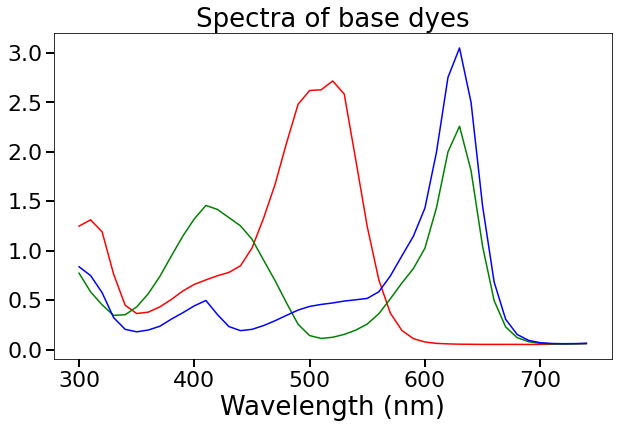

In [5]:
# plot basis spectra
fig, ax = plt.subplots(figsize=(10,6))
fontsize = 20

plt.plot(wavelength, RED, c='r')
plt.plot(wavelength, GREEN, c='g')
plt.plot(wavelength, BLUE, c='b')

plt.xlabel("Wavelength (nm)", fontsize=fontsize+6)
plt.title("Spectra of base dyes", fontsize=fontsize+6)

plt.xticks(fontsize=fontsize+2)
plt.yticks(fontsize=fontsize+2)

ax.tick_params(direction='out', width=2, length=8)
ax.tick_params(direction='out', which='minor', width=1, length=5)

plt.show()

In [6]:
# Initializing experimental constraints and thus determining parameter space
#constraints
min_conc = 0.05
max_conc = 1

# parameter space
N = 20
coeffs = np.linspace(min_conc, max_conc, N)
print(f"Possible coeffs: {coeffs}")

# all possible actions
Action_Set = np.array(list(itertools.product(coeffs, repeat=3)))
num_permutes = Action_Set.shape[0]
print(f"Actions set shape: {Action_Set.shape}")

Possible coeffs: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]
Actions set shape: (8000, 3)


In [7]:
def add_noise_to_output(Y, sig=0.1):
    """Add random gaussian noise to output."""
    noise = np.random.normal(loc=0.0, scale=sig, size=Y.shape)
    return Y + noise 

def add_systematic_low_to_actions(actions_tuple, err_percent=0.05):
    """Takes aech action and makes the result actually lower."""
    a, b, c = actions_tuple
    return [action*(1 - err_percent) for action in actions_tuple]

def add_systematic_high_to_actions(actions_tuple, err_percent=0.05):
    """Takes aech action and makes the result actually higher."""
    return [action*(1 + err_percent) for action in actions_tuple]

def add_randomness_to_actions(actions_tuple, sig=0.1):
    """Takes aech action and makes the result actually random."""
    noise = np.random.normal(loc=0.0, scale=sig, size=len(actions_tuple))
    return actions_tuple + noise

def normalize_to_fraction(action):
    """Returns the fraction of total volume given the concentrations (action)."""
    total = np.sum(action)
    return action/total

def spectra_from_conc(action, RED, GREEN, BLUE):
    """Transforms actions and input into output."""
    fract = normalize_to_fraction(action)
    return RED*fract[0] + GREEN*fract[1] + BLUE*fract[2]

def get_output(actions, X):
    """Transforms actions and input into output."""
    return actions[0]*X**2 + actions[1]*X + actions[2]

### Generating data with a systematic error such that the real cooefficients are actually less than reported.

In [8]:
# num_repeats = 5
# Y = np.zeros((num_permutes*num_repeats,N))
# # targets are polynomial using actions as coeffs
# for i in range(num_permutes):
#     actions = Action_Set[i]
#     for j in range(num_repeats):
#         # systematic low to coeffs
#         low_actions = add_systematic_low_to_actions(actions)
#         Y[i + num_permutes*j] = add_noise_to_output(get_output(low_actions, X))

# print(Y.shape)

In [9]:
# Getting fake data with noise + systematic low concentraions
num_repeats = 5
Y = np.zeros((num_permutes*num_repeats, x_dimension))
# targets are polynomial using actions as coeffs
for i in range(num_permutes):
    actions = Action_Set[i]
    for j in range(num_repeats):
        # systematic low to coeffs
        low_actions = add_systematic_low_to_actions(actions)
        spectra = spectra_from_conc(low_actions, RED, GREEN, BLUE)
        Y[i + num_permutes*j] = add_noise_to_output(spectra)

print(Y.shape)

(40000, 45)


In [10]:
Dataset = np.tile(Action_Set, (num_repeats,1))
Dataset.shape

(40000, 3)

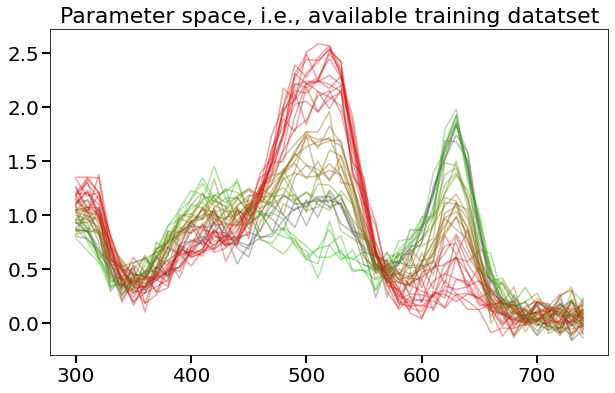

In [11]:
# displaying data
fig, ax = plt.subplots(figsize=(10,6))
fontsize = 16

Colors = np.array([normalize_to_fraction(c) for c in Action_Set])
Colors = np.tile(Colors, (num_repeats, 1))

for i in range(len(Y)):
    if not i % 1000:
        plt.plot(wavelength, Y[i], '-', c=Colors[i], alpha=0.4)

plt.xticks(fontsize=fontsize+4)
plt.yticks(fontsize=fontsize+4)

plt.title("Parameter space, i.e., available training datatset", fontsize=fontsize+6)

ax.tick_params(direction='out', width=2, length=8)
ax.tick_params(direction='out', which='minor', width=1, length=5)

plt.show()

### Creating "target" spectra

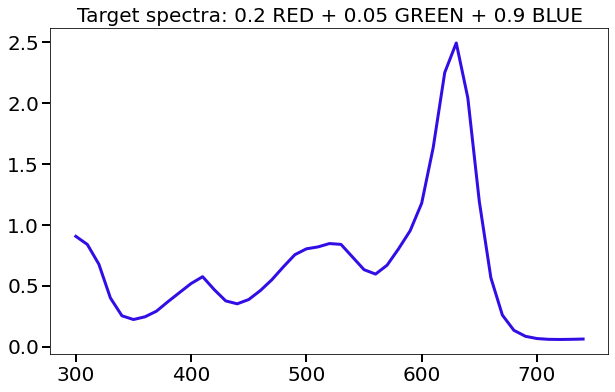

In [12]:
# create wanted "target"
target_action = (0.2, 0.05, 0.9)
target = spectra_from_conc(target_action, RED, GREEN, BLUE)

fig, ax = plt.subplots(figsize=(10,6))
fontsize = 16

plt.plot(wavelength, target, '-', c=target_action, linewidth=3)

plt.title(f"Target spectra: {target_action[0]} RED + {target_action[1]} GREEN + {target_action[2]} BLUE", fontsize=20)
plt.xticks(fontsize=fontsize+4)
plt.yticks(fontsize=fontsize+4)

ax.tick_params(direction='out', width=2, length=8)
ax.tick_params(direction='out', which='minor', width=1, length=5)

plt.show()

### Defining a metric (MSE is an error metric, se we want to minimize this)

In [13]:
def MSE(Y, target):
    return np.sum((Y-target)**2, axis=1)/Y.shape[0]

In [14]:
Pearsons = []
for y in Y:
    Pearsons.append(pearsonr(y, target)[0])

In [15]:
def get_cos_sim(target, y):
    return np.average(cosine_similarity(target.reshape(1, -1), Y=y.reshape(1, -1)).squeeze())
    
Cos = []
for y in Y:
    Cos.append(get_cos_sim(target, y))

In [16]:
mse = np.round(MSE(Y, target), 6)

In [17]:
# create dataframe
columns = ['a', 'b', 'c']
df = pd.DataFrame(data=Dataset, columns=columns)
df['MSE'] = mse
df['Pearsons'] = Pearsons
df['Cos'] = Cos
df

,a,b,c,MSE,Pearsons,Cos
0,0.05,0.05,0.05,0.000114,0.815229,0.928358
1,0.05,0.05,0.10,0.000037,0.947406,0.977068
2,0.05,0.05,0.15,0.000023,0.971219,0.986302
3,0.05,0.05,0.20,0.000013,0.981056,0.992178
4,0.05,0.05,0.25,0.000014,0.979686,0.991740
...,...,...,...,...,...,...
39995,1.00,1.00,0.80,0.000123,0.806349,0.923122
39996,1.00,1.00,0.85,0.000133,0.789642,0.918198
39997,1.00,1.00,0.90,0.000107,0.828812,0.933087
39998,1.00,1.00,0.95,0.000117,0.810544,0.926631


# UCB1

In [18]:
def ucb1_policy(df, time_step, column_names, metric='Cos', batch_size=3, ucb_scale=2.0):
    '''
    Applies UCB1 policy to generate recommendations.
    
    This is adapted from the tutorial found at
    https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/
    
    Arguments:
        df - dataset on which to apply UCB policy
            type == dataframe
        time_step - current time step (start at 1)
            type == int
        column_names - list of action names, i.e., df column names
            type == list
        batch_size - the number of recommendations to give
            default = 3
            type == int
        ucb_scale - the scale of the upper bound
            default = 2.0
            type == float
    Returns:
        actions - a subset of the data with the highest ucb
            type == dataframe        
    '''
    grouped_df = df.groupby(column_names)
    grouped_df = grouped_df.agg(['mean', 'count', 'std'])
    
    grouped_df['ucb'] = grouped_df[(metric, 'mean')] + \
        np.sqrt(2*np.log(time_step) / grouped_df[(metric, 'count')])
        # Gaussian
#         2 * grouped_df[('MSE', 'mean')] / np.sqrt(grouped_df[('MSE', 'mean')])
    
    # flip the MSE
    grouped_df['ucb'] = -grouped_df['ucb']
    
    scores = grouped_df.sort_values('ucb', ascending=False)

    recs = scores.index[:batch_size].values
    return recs

### Implement the UCB1 policy

In [19]:
# Get recomendations for 5 time steps
Recomendations = []
total_time_steps = 5
for t in range(total_time_steps):
    recs = ucb1_policy(df, t + 1, columns, batch_size=1)
    Recomendations.append(recs)

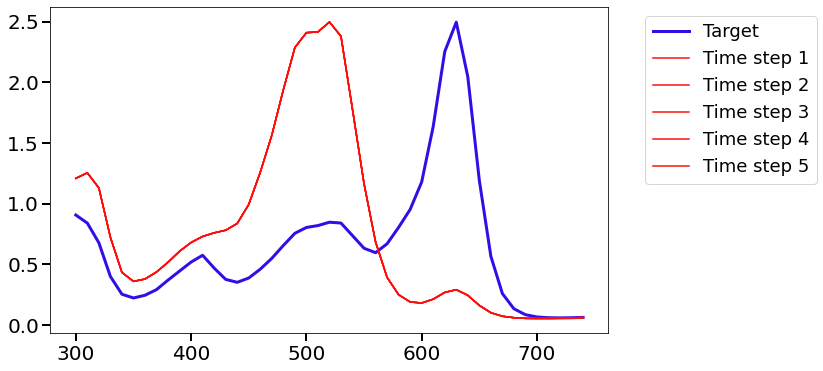

In [20]:
# displaying data
def plot_result_of_action_set(Recomendations, cm=plt.cm.viridis, ncols=1):
    total_time_steps = len(Recomendations)
    
    fig, ax = plt.subplots(figsize=(10,6))
    fontsize = 16

    Colors = cm(np.arange(total_time_steps)/(total_time_steps-1))

    plt.plot(wavelength, target, '-', c=target_action, linewidth=3, label="Target")

    for t in range(total_time_steps):
        i = 0
        if type(Recomendations[t][0]) is tuple:
            action =  Recomendations[t][0]
        else:
            action = Recomendations[t]
        low_action = add_systematic_low_to_actions(action)
        if i == 0:
            plt.plot(wavelength, spectra_from_conc(low_action, RED, GREEN, BLUE), '-',
                     c=action, label=f"Time step {t+1}")
        else:
            plt.plot(wavelength, spectra_from_conc(low_action, RED, GREEN, BLUE), '-',
                     c=action)
        i += 1

    plt.xticks(fontsize=fontsize+4)
    plt.yticks(fontsize=fontsize+4)

    ax.tick_params(direction='out', width=2, length=8)
    ax.tick_params(direction='out', which='minor', width=1, length=5)

    plt.legend(fontsize=18, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=ncols)
    plt.show()
    
    
plot_result_of_action_set(Recomendations)

### The UCB1 algorithm seems to be able to pick up systematic low errors. However, the time step does not seem to affect the recommendations...

# GP-UCB

In [21]:
# from https://github.com/tushuhei/gpucb

In [22]:
ucb = reload(ucb)

In [23]:
x = np.arange(-3, 3, 0.25)
y = np.arange(-3, 3, 0.25)
grid = np.meshgrid(x, y)

In [24]:
class DummyEnvironment(object):
    def sample(self, x):
        return np.sin(x[0]) + np.cos(x[1])

In [25]:
np.array(grid).shape

(2, 24, 24)

In [26]:
env = DummyEnvironment()
agent = ucb.GPUCB(grid, env)

In [27]:
agent.X_grid.shape

(576, 2)

In [28]:
np.array(agent.X).shape

(0,)

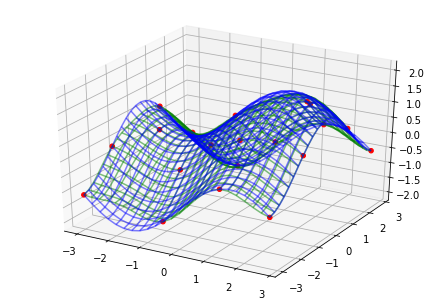

In [29]:
for i in range(20):
    agent.learn()

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(agent.meshgrid[0], agent.meshgrid[1],
agent.mu.reshape(agent.meshgrid[0].shape), alpha=0.5, color='g')
ax.plot_wireframe(agent.meshgrid[0], agent.meshgrid[1],
agent.environment.sample(agent.meshgrid), alpha=0.5, color='b')
ax.scatter([x[0] for x in agent.X], [x[1] for x in agent.X], agent.Y, c='r',
            marker='o', alpha=1.0)

In [30]:
# modifying it to work with this toy example

In [31]:
class Environment(object):
    def __init__(self, target, RED, GREEN, BLUE):
        # in future this will be basis spectra
        self.target = target
        self.RED = RED
        self.GREEN = GREEN
        self.BLUE = BLUE
    
    def sample(self, action):
        # add systematic low here
        # get output was defined above
        result = spectra_from_conc(action, self.RED, self.GREEN, self.BLUE)
        metric = get_cos_sim(target, result)
        return metric

In [32]:
param_space = np.meshgrid(coeffs, coeffs, coeffs)
print(np.array(param_space).shape)

(3, 20, 20, 20)


In [33]:
env = Environment(target, RED, GREEN, BLUE)
agent = ucb.GPUCB(param_space, env)

In [34]:
# training loop
for i in range(10):
    agent.learn()

In [35]:
agent.X

[array([0.05, 0.05, 0.05]),
 array([1., 1., 1.]),
 array([0.05, 0.05, 1.  ]),
 array([1.  , 0.05, 0.05]),
 array([0.05, 1.  , 0.05]),
 array([0.05, 1.  , 1.  ]),
 array([1.  , 0.05, 1.  ]),
 array([1.  , 1.  , 0.05]),
 array([0.5 , 0.55, 0.55]),
 array([0.5, 0.5, 1. ])]

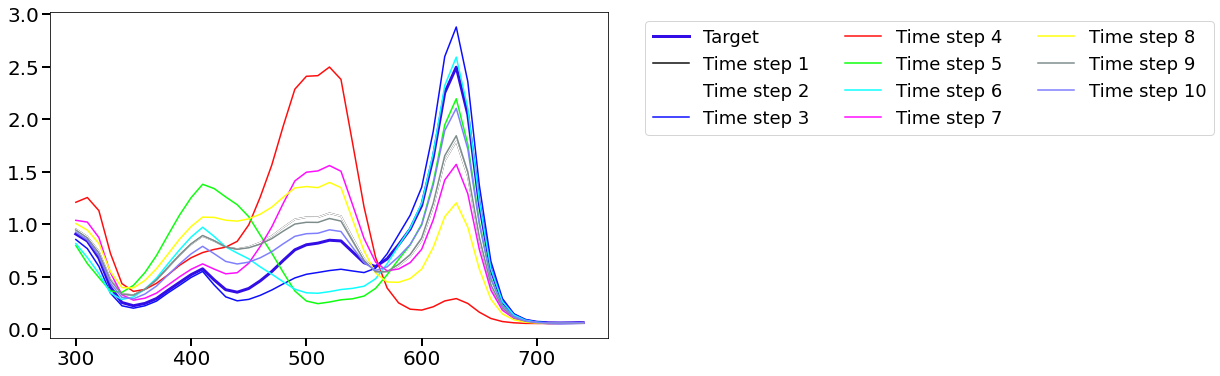

In [36]:
plot_result_of_action_set(agent.X, cm=plt.cm.Blues, ncols=3)

In [37]:
# Possible directions forward -- a better metric for spectra (i.e. KL divergence)
# or learning spectra insted of the metric... just change dimesnionality of mus and sigmas?

# Batch GP-UCB

In [38]:
ucb = reload(ucb)
x = np.arange(-3, 3, 0.25)
y = np.arange(-3, 3, 0.25)
grid = np.meshgrid(x, y)
print(np.array(grid).shape)

env = DummyEnvironment()
batch_size = 5
agent = ucb.BatchGPUCB(batch_size, grid, env)

(2, 24, 24)


In [39]:
# training loop
for i in range(10):
    agent.learn()    

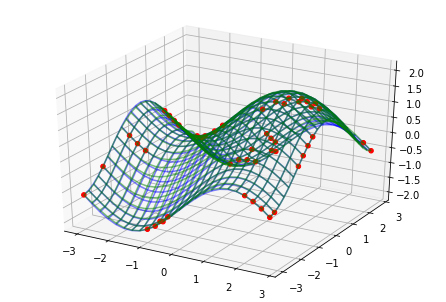

In [40]:
Recs = np.array(agent.X).squeeze().reshape(-1, 2)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(agent.meshgrid[0], agent.meshgrid[1],
    agent.mu.reshape(agent.meshgrid[0].shape), alpha=0.5, color='g')
ax.plot_wireframe(agent.meshgrid[0], agent.meshgrid[1],
    agent.environment.sample(agent.meshgrid), alpha=0.5, color='b')
ax.scatter([x[0] for x in Recs], [x[1] for x in Recs], agent.Y, c='r',
            marker='o', alpha=1.0)

### Spectra CP-BUCB

In [41]:
# spectra toy model
batch_size = 8
env = Environment(target, RED, GREEN, BLUE)
agent = ucb.BatchGPUCB(batch_size, param_space, env)
# training loop
epochs = 10
for i in range(epochs):
    agent.learn()

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predic

In [42]:
Recs = np.array(agent.X).squeeze().reshape(-1, 3)
Recs.shape

(80, 3)

In [43]:
def plot_batch(Recomendations, epoch):
    fig, ax = plt.subplots(figsize=(6,4))
    fontsize = 16

    total_time_steps = Recomendations.shape[0]

    plt.plot(wavelength, target, 'k-', linewidth=5, label="Target")

    for i in range(total_time_steps):
        action =  Recomendations[i]
        low_action = add_systematic_low_to_actions(action)
        plt.plot(wavelength, spectra_from_conc(low_action, RED, GREEN, BLUE), '-',
                 c=action, alpha=0.4)
        i += 1

    plt.xticks(fontsize=fontsize+4)
    plt.yticks(fontsize=fontsize+4)
    plt.title(f"Epoch {epoch}", fontsize=20)

    ax.tick_params(direction='out', width=2, length=8)
    ax.tick_params(direction='out', which='minor', width=1, length=5)

    plt.show()

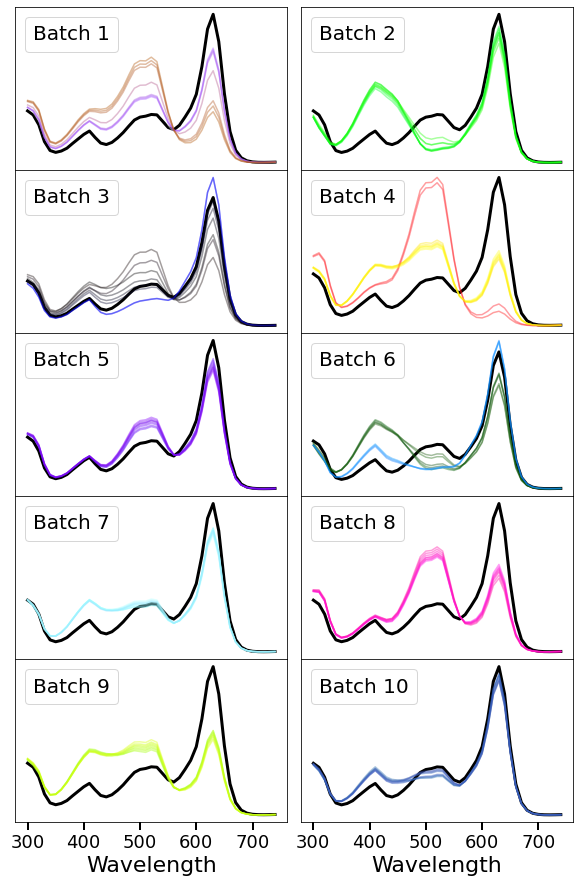

In [44]:
def plot_batch_stack(Recomendations, batch_size, epochs):
    
    nrows = epochs//2
    fig, axes = plt.subplots(figsize=(10,15), nrows=nrows, ncols=2)
    fontsize = 16

    total_steps = Recomendations.shape[0]
    
    # formatting loop
    for i, ax in enumerate(axes.flatten()):
        # ticks
        ax.tick_params(direction='out', width=2, length=8)
        ax.tick_params(direction='out', which='minor', width=1, length=5)
        ax.set_yticks([])
        
        if i in [epochs-2, epochs-1]:
            ax.set_xticks(np.arange(300, 701, 100))
            ax.tick_params(axis='x', labelsize=fontsize+2)
            ax.set_xlabel("Wavelength", fontsize=fontsize+6)
        else:
            ax.set_xticks([])
     
    # actually plotting loop
    for i, ax in enumerate(axes.flatten()):
        # target
        ax.plot(wavelength, target, 'k-', linewidth=3, label="Target")
        # get batch
        batch = i
        base = i*batch_size
        subset = Recs[base : base + batch_size]
        for action in subset:
            low_action = add_systematic_low_to_actions(action)
            ax.plot(wavelength, spectra_from_conc(low_action, RED, GREEN, BLUE), '-',
                 c=action, alpha=0.4)
        # setting legend as batch label
        legend = ax.legend([f'Batch {i+1}'], fontsize=fontsize+4, handlelength=0,
                           handletextpad=0, fancybox=True,)
        for item in legend.legendHandles:
            item.set_visible(False)

    plt.subplots_adjust(hspace=0.0, wspace=0.05)
    plt.show()
    
plot_batch_stack(Recs, batch_size, epochs)